## Image Caption Generation 

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>



### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.




**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your full name: `Amiya Kumar Sur`

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torchtext
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm.notebook import tqdm
from PIL import Image
import re
import json
import warnings
warnings.filterwarnings('ignore')

Detect which device (CPU/GPU) to use.

In [2]:
if not torch.backends.mps.is_available():
    print('MPS Device Not Available')
else:
    device = torch.device("mps")

The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features 

> 1.1 Design a encoder layer with pretrained ResNet50 

> 1.2 Image feature extraction step 

#### 1.1 Design a encoder layer with pretrained ResNet50 

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [3]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
            features = features.view(features.size(0), -1)
            
        return features

In [4]:
encoder = EncoderCNN()
encoder.eval()

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [5]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [6]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [7]:
IMAGE_DIR = "coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        image = Image.open(os.path.join(IMAGE_DIR, filename)).convert('RGB')
        image_id = int(filename.split('.')[0].lstrip('0'))
        
        if self.transform:
            image = self.transform(image)


        return image, image_id

    def __len__(self):
        return len(self.df)
    

In [8]:
features_map = dict()

image_data = COCOImagesDataset(df_unique_files, transform=data_transform)
image_loader = DataLoader(image_data, batch_size=64, shuffle=False)

features_path = 'features.pth'

with torch.no_grad():
    for imgs, image_ids in tqdm(image_loader):
        features = encoder(imgs)
        for i, image_id in enumerate(image_ids):
            features_map[image_id.item()] = features[i].numpy()


torch.save(features_map, features_path)

  0%|          | 0/80 [00:00<?, ?it/s]

## 2 Text preparation 

> 2.1 Build the caption dataset 

> 2.2 Clean the captions 

> 2.3 Split the data 

> 2.4 Building the vocabulary 

> 2.5 Prepare dataset using dataloader 


#### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [9]:
with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [10]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("coco_subset_meta.csv")

# Merge the DataFrames to get the image filenames and captions
new_file = df.merge(coco_subset, left_on='image_id', right_on='id')

# Keep only the relevant columns
new_file = new_file[['image_id', 'file_name', 'caption']]
new_file.head()

,image_id,file_name,caption
0,57429,000000057429.jpg,An airplane with its landing wheels out landing.
1,57429,000000057429.jpg,A plane that is taking off at an airport
2,57429,000000057429.jpg,A man takes a picture of an airplane taking off.
3,57429,000000057429.jpg,A large jet takes off from an airport runway.
4,57429,000000057429.jpg,The airplane is taking off on the runway at th...


#### 2.2 Clean the captions 

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [11]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def clean_caption(caption):
    caption = caption.lower()
    caption = caption.strip()
    caption = re.sub('[^a-z]+', ' ', caption)
    caption = re.sub(' +', ' ', caption)
    return caption.strip()

In [12]:
def gen_clean_captions_df(df):
    clean_captions = []
    for index, row in df.iterrows():
        clean_caption_text = clean_caption(row['caption'])
        clean_captions.append(clean_caption_text)
    
    df["clean_caption"] = clean_captions
    
    return df

In [13]:
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,file_name,caption,clean_caption
0,57429,000000057429.jpg,An airplane with its landing wheels out landing.,an airplane with its landing wheels out landing
1,57429,000000057429.jpg,A plane that is taking off at an airport,a plane that is taking off at an airport
2,57429,000000057429.jpg,A man takes a picture of an airplane taking off.,a man takes a picture of an airplane taking off
3,57429,000000057429.jpg,A large jet takes off from an airport runway.,a large jet takes off from an airport runway
4,57429,000000057429.jpg,The airplane is taking off on the runway at th...,the airplane is taking off on the runway at th...
5,410627,000000410627.jpg,The young man is stirring his pot of food with...,the young man is stirring his pot of food with...
6,410627,000000410627.jpg,A man enjoys cooking food in a pan,a man enjoys cooking food in a pan
7,410627,000000410627.jpg,A smiling man is cooking in his kitchen.,a smiling man is cooking in his kitchen
8,410627,000000410627.jpg,A man smiles as he stirs his food in the pot.,a man smiles as he stirs his food in the pot
9,410627,000000410627.jpg,A boy smiles while holding a pot and spoon.,a boy smiles while holding a pot and spoon


#### 2.3  Split the data 

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [14]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [15]:
unique_ids = new_file['image_id'].unique()

train_ids, valid_ids, test_ids = split_ids(unique_ids)

In [16]:
# Create train, validation, and test DataFrames
train_df = new_file[new_file['image_id'].isin(train_ids)]
valid_df = new_file[new_file['image_id'].isin(valid_ids)]
test_df = new_file[new_file['image_id'].isin(test_ids)]

# Print the sizes of the train, validation, and test sets
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 28435
Validation set size: 3812
Test set size: 7766


#### 2.4 Building the vocabulary 

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [17]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [18]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word, count in word_mapping.items():
        if count > MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab


In [19]:
# build your vocabulary for train, valid and test sets
train_vocab = build_vocab(train_ids, new_file)
valid_vocab = build_vocab(valid_ids, new_file)
test_vocab = build_vocab(test_ids, new_file)

print("VOCAB DETAILS")
print(f"Train vocabulary size: {len(train_vocab)}")
print(f"Validation vocabulary size: {len(valid_vocab)}")
print(f"Test vocabulary size: {len(test_vocab)}")

VOCAB DETAILS
Train vocabulary size: 3167
Validation vocabulary size: 978
Test vocabulary size: 1426


In [21]:
def join_vocabs(vocab1, vocab2):
    joined_vocabs = Vocabulary()
    
    for word in vocab1.word2idx.keys():
        if word not in joined_vocabs.word2idx:
            joined_vocabs.add_word(word)

    for word in vocab2.word2idx.keys():
        if word not in joined_vocabs.word2idx:
            joined_vocabs.add_word(word)
    
    return joined_vocabs


vocab = join_vocabs(train_vocab, valid_vocab)
vocab = join_vocabs(vocab, test_vocab)

#### 2.5 Prepare dataset using dataloader 

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [22]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    def __init__(self, df, features, vocab):
        self.df = df
        self.features = features
        self.vocab = vocab

    def __getitem__(self, index):
        image_id = self.df.iloc[index]['image_id']
        image = torch.tensor(self.features[image_id], dtype=torch.float32).unsqueeze(0)
        caption = self.df.iloc[index]['clean_caption']
        
        all_tokens = caption.split()
        
        # including the <end> token in the count
        caption_ids = [self.vocab('<end>')] * MAX_SEQ_LEN
        for i, token in enumerate(all_tokens):
            if i < MAX_SEQ_LEN - 1:
                caption_ids[i] = self.vocab(token)
            else:
                break
                
        caption_tensor = torch.tensor(caption_ids, dtype=torch.long)
        true_length = min(len(all_tokens) + 1, MAX_SEQ_LEN)

        return image, caption_tensor, true_length

    def __len__(self):
        return len(self.df)
    
    
    
def caption_collate_fn(data):
    images, targets, lengths = zip(*data)
    images = torch.cat(images, dim=0)
    targets = torch.stack(targets, dim=0)
    lengths = torch.tensor(lengths, dtype=torch.long)
    
    return images, targets, lengths

In [23]:
train_set = new_file[new_file['image_id'].isin(train_ids)]
valid_set = new_file[new_file['image_id'].isin(valid_ids)]
test_set = new_file[new_file['image_id'].isin(test_ids)]

dataset_train = COCO_Features(train_set, features_map, vocab)
dataset_valid = COCO_Features(valid_set, features_map, vocab)
dataset_test = COCO_Features(test_set, features_map, vocab)

In [24]:
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, collate_fn=caption_collate_fn)
valid_loader = DataLoader(dataset_valid, batch_size=64, shuffle=False, collate_fn=caption_collate_fn)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, collate_fn=caption_collate_fn)

Load one batch of the training set and print out the shape of each returned Tensor.

In [25]:
images, captions, lengths = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Captions shape: {captions.shape}")
print(f"Lengths shape: {lengths.shape}")

Images shape: torch.Size([64, 2048])
Captions shape: torch.Size([64, 47])
Lengths shape: torch.Size([64])


## 3 Train DecoderRNN 

> 3.1 Design RNN-based decoder 

> 3.2 Train your model with precomputed features 

#### 3.1 Design a RNN-based decoder 

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, max_seq_length):
        super(DecoderRNN, self).__init__()

        self.resize = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        embeds = self.embed(captions)
        image_features = self.resize(features)
        image_features = self.bn(image_features)

        embeds = torch.cat((image_features.unsqueeze(1), embeds), 1)
        packed = pack_padded_sequence(embeds, lengths, batch_first=True)
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
            
        return outputs

    def sample(self, features, states=None):
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))  
            _, predicted = outputs.max(1)               
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              
            inputs = inputs.unsqueeze(1)      
            
        sampled_ids = torch.stack(sampled_ids, 1)  
        
        return sampled_ids

In [27]:
decoder = DecoderRNN(vocab_size=len(vocab), embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47)

#### 3.2 Train your model with precomputed features

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [28]:
batch_size = 64
epochs = 15
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

saved_model_path = 'my_decoder.pth'

In [29]:
for epoch in range(epochs):
    decoder.train()
    train_loss = 0.0
    for i, (images, captions, lengths) in enumerate(train_loader):
        sorted_lengths, sorted_indices = torch.sort(lengths, descending=True)
        sorted_captions = captions[sorted_indices]
        sorted_images = images[sorted_indices]

        targets = pack_padded_sequence(sorted_captions, sorted_lengths, batch_first=True).data
        optimizer.zero_grad()
        outputs = decoder(sorted_images, sorted_captions, sorted_lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / (i + 1))

    decoder.eval()
    valid_loss = 0.0
    for i, (images, captions, lengths) in enumerate(valid_loader):
        sorted_lengths, sorted_indices = torch.sort(lengths, descending=True)
        sorted_captions = captions[sorted_indices]
        sorted_images = images[sorted_indices]

        targets = pack_padded_sequence(sorted_captions, sorted_lengths, batch_first=True).data
        with torch.no_grad():
            outputs = decoder(sorted_images, sorted_captions, sorted_lengths)
            
        loss = criterion(outputs, targets)
        valid_loss += loss.item()

    valid_losses.append(valid_loss / (i + 1))
    print(f"Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.3f}, Validation Loss: {valid_losses[-1]:.3f}")

torch.save(decoder.state_dict(), saved_model_path)

Epoch: 1, Train Loss: 3.884, Validation Loss: 3.352
Epoch: 2, Train Loss: 2.761, Validation Loss: 3.187
Epoch: 3, Train Loss: 2.357, Validation Loss: 3.138
Epoch: 4, Train Loss: 2.063, Validation Loss: 3.170
Epoch: 5, Train Loss: 1.823, Validation Loss: 3.256
Epoch: 6, Train Loss: 1.625, Validation Loss: 3.294
Epoch: 7, Train Loss: 1.458, Validation Loss: 3.399
Epoch: 8, Train Loss: 1.322, Validation Loss: 3.489
Epoch: 9, Train Loss: 1.205, Validation Loss: 3.567
Epoch: 10, Train Loss: 1.107, Validation Loss: 3.668
Epoch: 11, Train Loss: 1.023, Validation Loss: 3.759
Epoch: 12, Train Loss: 0.952, Validation Loss: 3.841
Epoch: 13, Train Loss: 0.889, Validation Loss: 3.913
Epoch: 14, Train Loss: 0.840, Validation Loss: 4.006
Epoch: 15, Train Loss: 0.790, Validation Loss: 4.062


In [30]:
def plot():
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

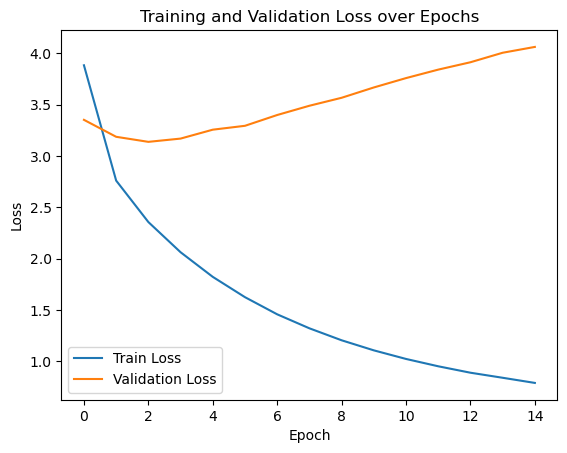

In [31]:
plot()

## 4 Generate predictions on test data 

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [32]:
def imageCaption(image, generatedCaption, referenceCaption):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print(f"Generated caption: {generatedCaption}")
    print("\nReference captions:")
    for idx, caption in enumerate(referenceCaption):
        print(f"{idx + 1}. {caption}")
        

def captionGenerator(model, image, vocab):
    model.eval()
    with torch.no_grad():
        features = encoder(image.unsqueeze(0))
        caption = model.sample(features)
        caption = caption.squeeze(0).cpu().numpy()
        words = [vocab.idx2word[token.item()] for token in caption if token.item() != 0]
        
    return ' '.join(words)

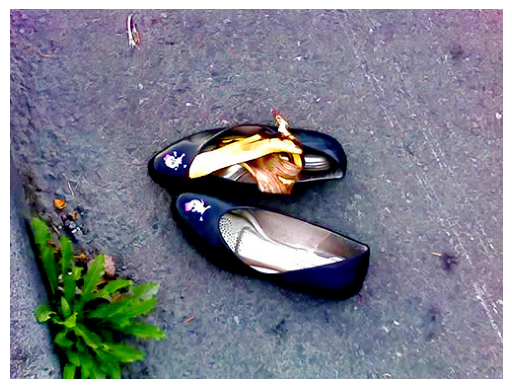

Generated caption: a <unk> is sitting on a large motorcycle <end> <end> <unk> <end> into the distance and the window of a street <end> <end> into the distance <unk> the <unk> of a building <end> <end> into the distance and the city street <end> the <unk> <unk> <unk> <end>

Reference captions:
1. a pair of shoes sitting on top of a street
2. a close of of a pair of shoes on the side of the road with a banana peel in them
3. two black shoes and banana peel on ground next to plant
4. a pair of shoes on the ground next to a plant
5. a pair of womans shoes on the ground


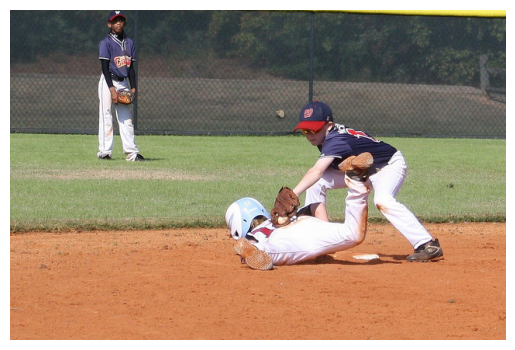

Generated caption: a baseball player swinging a bat at a ball <end> <end> <end> <end> with family in the background in the background in a room <end> <end> with candles in the background <end> <end> on the bathroom counter <end> with friends and family in the floor <end> of

Reference captions:
1. a little leaguer tagging another player with a baseball
2. a little leaguer tagging another player with a baseball
3. a kid sliding into a base and being tagged
4. a kid sliding into a base and being tagged
5. a man on the ground playing base ball
6. a man on the ground playing base ball
7. a baseball player slid into home base and the catcher is tagging him to get him out meanwhile the pitcher is looking intently at the plate
8. a baseball player slid into home base and the catcher is tagging him to get him out meanwhile the pitcher is looking intently at the plate
9. a child laying on its stomach at a baseball game s base
10. a child laying on its stomach at a baseball game s base


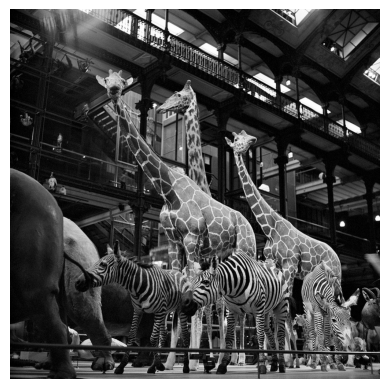

Generated caption: a <unk> of five people are standing in the street <end> <end> <end> with <unk> <unk> in <unk> background <end> on <unk> the snow <end> <unk> <end> and <unk> his snow <unk> <end> <unk> <end> and <unk> <unk> <end> skiing in the snow <end> <end> with <unk>

Reference captions:
1. an indoor area with sculptures of various animals including giraffes and zebras
2. an indoor area with sculptures of various animals including giraffes and zebras
3. an indoor area with sculptures of various animals including giraffes and zebras
4. sculptures of zebras giraffes hippo rhino and elephant in an open room
5. sculptures of zebras giraffes hippo rhino and elephant in an open room
6. sculptures of zebras giraffes hippo rhino and elephant in an open room
7. a display of giraffes zebras and elephants in a building
8. a display of giraffes zebras and elephants in a building
9. a display of giraffes zebras and elephants in a building
10. three giraffes three zebras and other animals in a 

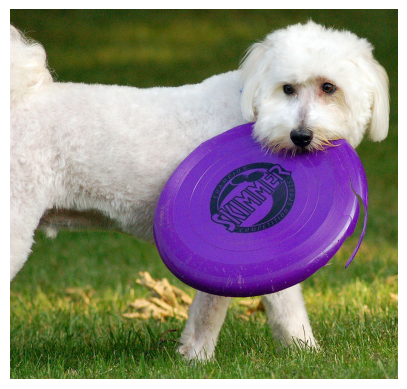

Generated caption: a dog with a frisbee in its mouth <end> on the board <end> his swing <end> the distance and the side of the mountain <end> <end> with trees in the background <end> <end> with <unk> <end> in the distance <end> the door is <unk> <end> with <unk>

Reference captions:
1. a white dog holding a purple frisbee in it s mouth
2. a white dog is holding a frisbee in its mouth waiting to play
3. white dog carrying a purple frisbee on a lawn
4. a white dog has a purple frisbee in it s mouth
5. a dog is holding a frisbee standing on grass


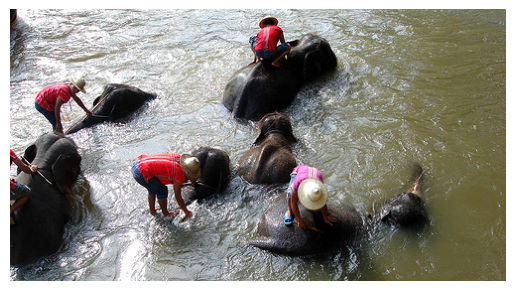

Generated caption: a group of people riding on the backs of horses on a beach <end> <end> <end> <end> for <unk> <end> <end> in the distance <end> <end> of business <end> in the distance and the city street in the evening <unk> <end> <end> of various types of lights

Reference captions:
1. some people are washing elephants in the water
2. these people are washing their elephants in the river
3. a group of people out in a body of water helping elephants wash themselves
4. elephants being bathed in a body of water by people in sun hats
5. a group of people that are in the water with elephants


In [33]:
numSamples = 5

def assign_split(image_id):
    if image_id in train_ids:
        return 'train'
    elif image_id in valid_ids:
        return 'valid'
    elif image_id in test_ids:
        return 'test'
    else:
        return None

new_file['split'] = new_file['image_id'].apply(assign_split)
test_df = new_file[new_file['split'] == 'test']
random_indices = np.random.choice(test_df.index, numSamples)

for index in random_indices:
    image_id = test_df.loc[index, 'image_id']
    file_name = test_df.loc[index, 'file_name']
    image = Image.open(os.path.join(IMAGE_DIR, file_name)).convert('RGB')
    image_tensor = data_transform(image)

    generatedCaption = captionGenerator(decoder, image_tensor, vocab)
    referenceCaption = test_df[test_df['image_id'] == image_id]['clean_caption'].tolist()

    imageCaption(image, generatedCaption, referenceCaption)


## 5 Caption evaluation using BLEU score

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data 

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data 


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

Average BLEU score: 0.011796274519492746


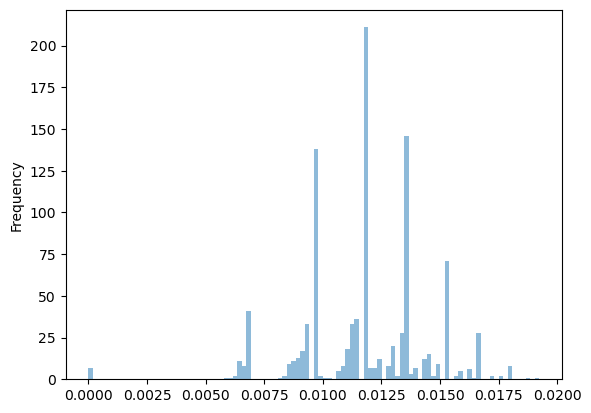

In [35]:
ref_captions_dict = test_df.groupby('image_id')['clean_caption'].apply(list).to_dict()

stats = pd.DataFrame(columns=['ref', 'preds', 'bleu'])

for image_id, file_name in test_df[['image_id', 'file_name']].drop_duplicates().itertuples(index=False):
    ref_captions = ref_captions_dict[image_id]

    image = Image.open(os.path.join(IMAGE_DIR, file_name)).convert('RGB')
    image_tensor = data_transform(image)
    generated_caption = captionGenerator(decoder, image_tensor, vocab)
    
    smoothing_function = SmoothingFunction().method1
    bleu_score = sentence_bleu(ref_captions, generated_caption.split(), weights=(0.5, 0.5), smoothing_function=smoothing_function)
    
    stats = stats.append({'ref': ref_captions, 'preds': generated_caption, 'bleu': bleu_score}, ignore_index=True)
    
    

print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples 

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [36]:
highScore = stats.loc[stats['bleu'].idxmax()]
lowScore = stats.loc[stats['bleu'].idxmin()]

print('---------------HIGH SCORE---------------')
print("BLEU Score: ", highScore['bleu'])
print("Generated Caption: ", highScore['preds'])
print("Reference Captions: ", highScore['ref'])

print("---------------LOW SCORE---------------")
print("BLEU Score:", lowScore['bleu'])
print("Generated Caption:", lowScore['preds'])
print("Reference Captions:", lowScore['ref'])

---------------HIGH SCORE---------------
BLEU Score:  0.019236105429150833
Generated Caption:  a desk with laptop a couch a table and a chair <end> of books <end> and books next to a desk with a lamp and books <end> <end> of books and a lamp are on the floor <end> <end> into the mirror and a bed one <unk>
Reference Captions:  ['a laptop on a table near a window with a view of the outdoors', 'a desk some windows and a laptop computer', 'a desk is shown with a computer screen on', 'a lap top on a desk by a window', 'a lap top computer sits in the center of a desk in an empty room overlooking a residential landscape']
---------------LOW SCORE---------------
BLEU Score: 0.0
Generated Caption: the dog is playing and in the snow with trees in the background <end> <end> the <unk> and <unk> <end> <end> <end> for photo <end> <end> with trees in the background on the ground <end> <end> <end> into the distance <end> the <unk> for the sky <end>
Reference Captions: ['a woman sitting next to a yello

## 6 Caption evaluation using cosine similarity

> 6.1 Cosine similarity 

> 6.2 Cosine similarity examples 

####  6.1 Cosine similarity 

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

Average Cosine Similarity:  0.8452816159267144


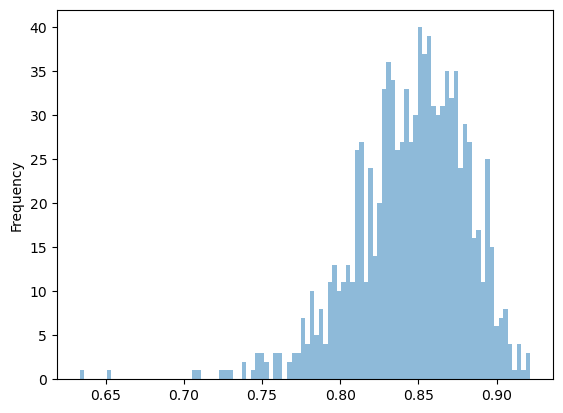

In [37]:
glove = torchtext.vocab.GloVe(name='6B', dim=300)

def embedAverage(sentence, embedding_model):
    tokens = sentence.split()
    embeddings = [embedding_model[token].numpy() for token in tokens if token in embedding_model.stoi]
    
    if len(embeddings) == 0:
        return np.zeros(embedding_model.dim)
    
    return np.mean(embeddings, axis=0)

stats['cos_sim'] = 0
for index, row in stats.iterrows():
    ref_captions = row['ref']
    generated_caption = row['preds']

    ref_vectors = [embedAverage(caption, glove) for caption in ref_captions]
    generated_vector = embedAverage(generated_caption, glove)

    similarities = [cosine_similarity(generated_vector.reshape(1, -1), ref_vec.reshape(1, -1))[0][0] for ref_vec in ref_vectors]
    avg_similarity = np.mean(similarities)

    stats.at[index, 'cos_sim'] = avg_similarity

print("Average Cosine Similarity: ", stats['cos_sim'].mean())
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5)

#### 6.2 Cosine similarity examples 

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [38]:
highCos = stats.loc[stats['cos_sim'].idxmax()]
lowCos = stats.loc[stats['cos_sim'].idxmin()]

print("--------High Cosine--------")
print("Generated caption:", highCos['preds'])
print("Cosine Similarity:", highCos['cos_sim'])
print("Reference captions:")
for caption in highCos['ref']:
    print(caption)

print("\n--------Low Cosine--------")
print("Generated caption:", lowCos['preds'])
print("Cosine Similarity:", lowCos['cos_sim'])
print("Reference captions:")
for caption in lowCos['ref']:
    print(caption)

--------High Cosine--------
Generated caption: a desk with a laptop and a monitor and keyboard on it <end> <end> on the front of a desk <end> <end> with <unk> <end> <unk> and <unk> <unk> <end> it with books <unk> up on the floor <end> and four objects <end> <end> chairs and window
Cosine Similarity: 0.9216192960739136
Reference captions:
a cluttered desk with several computers on it
a cluttered desk with several computers on it
a cluttered desk with several computers on it
a small desk is cluttered with a white lap top a monitor and a silver laptop and a computer mouse
a small desk is cluttered with a white lap top a monitor and a silver laptop and a computer mouse
a small desk is cluttered with a white lap top a monitor and a silver laptop and a computer mouse
there are three computers on the desk all on at the same time
there are three computers on the desk all on at the same time
there are three computers on the desk all on at the same time
two laptops and a desktop are lined up on 

## 7 Comparing BLEU and Cosine similarity
> 7.1 Test set distribution of scores

> 7.2 Analysis of individual examples 

#### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [39]:
avgBleu = stats['bleu'].mean()
avgCos = stats['cos_sim'].mean()

reCos = (avgCos + 1) / 2

print("Average BLEU score: ", avgBleu)
print("Rescaled cosine similarity: ", reCos)

Average BLEU score:  0.011796274519492746
Rescaled cosine similarity:  0.9226408079633572


 #### 7.2 Analysis of individual examples 
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [40]:
stats['score_diff'] = abs((stats['cos_sim'] + 1) / 2 - stats['bleu'])

simScore = stats.loc[stats['score_diff'].idxmin()]
notSimScore = stats.loc[stats['score_diff'].idxmax()]

print("Example with similar scores:")
print("Generated caption:", simScore['preds'])
print("BLEU score:", simScore['bleu'])
print("Cosine similarity:", simScore['cos_sim'])
print("Reference captions:")
for caption in simScore['ref']:
    print(caption)

print("\n Example with dissimilar scores:")
print("Generated caption:", notSimScore['preds'])
print("BLEU score:", notSimScore['bleu'])
print("Cosine similarity:", notSimScore['cos_sim'])
print("Reference captions:")
for caption in notSimScore['ref']:
    print(caption)

Example with similar scores:
Generated caption: an image of a man skateboarding at a skate park <end> <end> <end> with many people watch <end> <unk> <end> into the distance <unk> the slope <unk> <unk> <end> and <unk> up snow <unk> back yard while he is <unk> down the slope <end> a <unk> <unk>
BLEU score: 0.010590860360011705
Cosine similarity: 0.6333528161048889
Reference captions:
baggage handlers are an airport loading luggage onto a plane
baggage handlers are an airport loading luggage onto a plane
three airport workers loading luggage onto the truck
three airport workers loading luggage onto the truck
luggage handlers unloading many suitcases at an airport
luggage handlers unloading many suitcases at an airport
airport baggage handlers loading luggage into a cart
airport baggage handlers loading luggage into a cart
three young men are piling luggage into a storage container
three young men are piling luggage into a storage container

 Example with dissimilar scores:
Generated capti